## Cleaning TV2 & DR datasets and basic statistics

In [383]:
import requests
import time
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
import tqdm
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

### Import datasets

In [425]:
# Import TV2 dataset
tv2 = pd.read_csv('articles_tv2.csv')
display(len(tv2))

8758

In [385]:
dr = pd.read_csv('dr_articles.csv')
display(len(dr))

2065

TV2: The raw dataset after scraping websites from links has 8758 articles.

DR: The raw dataset after scraping websites from links has 2065 articles. 

### Diverse cleaning operations

#### TV2 Dataset

In [426]:
## Rows that stem from links to a search page. They have the title "Søg på TV 2" and can be deleted
tv2 = tv2[tv2.titles != 'Søg på TV 2'].reset_index(drop = True)
# After this step, 7416 observations remain
# In the next step we drop all rows that do not contain values. These are sports artciles like this one: https://sport.tv2.dk/2012-02-26-sur-s%C3%B8d-fornemmelse-hos-kasper-hvidt
tv2 = tv2.dropna(subset = ['content'])
# Rename column
tv2.rename(columns = {'tv2':'source'}, inplace = True)
# Reset index
tv2 = tv2.reset_index(drop = True)
# Change date to date_time objects
tv2['date'] = pd.to_datetime(tv2['date'])
# Drop articles published outside period of interest (2012-2022)
tv2 = tv2[tv2['date'].dt.year >= 2012]
# Drop duplicates
tv2 = tv2.drop_duplicates(subset="content")
len(tv2)

4473

Number of observations and rows: TV2 dataset now contains 4473 articles.

#### DR Dataset

We found 538 observations for which no content was retrieved. These include articles with a different HTML structure (see, e.g.: 'https://www.dr.dk/nyheder/region-ingen-fare-patienter-paa-holbaek-sygehus?focusId=3406239'). Unfortunately, our scraping code did not account for this structure. If we had more time, we would go back, adapt the code and get the content of these articles. For the purpose of this limited analysis, we continue without those articles.

In [387]:
dr = dr.dropna(subset = ["content"]).reset_index(drop = True)

In [427]:
dr['date'] = pd.to_datetime(dr['date'])
dr = dr[dr['date'].dt.year >= 2012].copy()
dr = dr.drop_duplicates(subset="content")
len(dr)

1470

After dropping observations without content, 1470 articles remain.

#### Columns of DR and TV datasets: 
* `titles` contains the articles' title
* `sub_header` contains the articles' subheader
* `h2` contains any headline found in the article 
* `author` contains the author of the article 
* `tag` contains any tags that TV2 added to the article: e.g. "udland". 
* `source` will later indicate the source 
* `links` contains the link to the original article
* `date` contains date in the datetime formate

#### Cleaning articles' content

In [390]:
def cleaning_texts(df):
    '''
    Function cleans the text of the "content", "titles", "subheaders" and "h2" columns of TV2 and DR datasets.
    '''
    df_new = df.copy()
    for i in tv2[['titles', 'sub_header', 'h2', 'content', 'author']]:
        df_new[i] = df_new[i].str.lower()\
            .str.replace('\r', '')\
            .str.replace('\n', '')\
            .str.replace('\xa0', '')
    return df_new

In [391]:
# Cleaning datasets with cleaning function
tv2 = cleaning_texts(tv2)
dr = cleaning_texts(dr)

### Creating more relevant datasets

Creating different DataFrames according to the number of times "sygeplej*" is found in the articles' content. The more frequently the term features in the text, the more relevant the articles' should be for our analysis. 

_For now, we continue working with data in which "sygeplej*" appears at least twice_.

In [363]:
### Defining function

In [393]:
# Create different datasets with "sygeplej*" featuring at least X times in the text
def sygeplej_count(df):
    df_sygeplej1x = df[df['content'].str.count("sygeplej") >= 1]
    df_sygeplej2x = df[df['content'].str.count("sygeplej") >= 2]
    df_sygeplej3x = df[df['content'].str.count("sygeplej") >= 3]
    df_sygeplej4x = df[df['content'].str.count("sygeplej") >= 4]
    return df_sygeplej1x, df_sygeplej2x, df_sygeplej3x, df_sygeplej4x

In [394]:
tv2_sygeplej1x, tv2_sygeplej2x, tv2_sygeplej3x, tv2_sygeplej4x = sygeplej_count(tv2)
dr_sygeplej1x, dr_sygeplej2x, dr_sygeplej3x, dr_sygeplej4x = sygeplej_count(dr)

In [396]:
dict_sygeplej_count = {"sygeplej* count":\
                       ['At least once', 'At least twice', 'At least three times', 'More than three times'],\
                       "Num. of articles (TV2)" :\
                       [len(tv2_sygeplej1x), len(tv2_sygeplej2x), len(tv2_sygeplej3x), len(tv2_sygeplej4x)],\
                      "Num. of articles (DR)" :\
                       [len(dr_sygeplej1x), len(dr_sygeplej2x), len(dr_sygeplej3x), len(dr_sygeplej4x)]}

table_sygeplej_count = pd.DataFrame(data = dict_sygeplej_count)
display(table_sygeplej_count)

,sygeplej* count,Num. of articles (TV2),Num. of articles (DR)
0,At least once,3607,660
1,At least twice,1511,528
2,At least three times,909,458
3,More than three times,668,392


## Frequency of Articles by Date

Defining function for plotting frequencies of articles:

In [ ]:
dr_2022['content'][1226]

In [398]:
def frequency_table(df):
    df['year']=pd.to_datetime(df["date"]).dt.year
    df['month']=pd.to_datetime(df["date"]).dt.month
    df_freq=df.copy()
    df_freq = df_freq.dropna(subset = ['year', 'month'])

    df_freq1, df_freq2, df_freq3, df_freq4=sygeplej_count(df_freq)
    
    freq1 = df_freq1.groupby(['year', 'month'])["content"].count().unstack(fill_value=0).stack()
    
    df_freq1x=pd.DataFrame(freq1).reset_index(drop=False)
    df_freq1x=df_freq1x.rename(columns={0:'content'})
    freq1.reset_index(drop=False)
    
    freq2 = df_freq2.groupby(['year', 'month'])["content"].count().unstack(fill_value=0).stack()
    df_freq2x=pd.DataFrame(freq2).reset_index(drop=True)
    df_freq2x=df_freq2x.rename(columns={0:'content'})

    freq3 = df_freq3.groupby(['year', 'month'])["content"].count().unstack(fill_value=0).stack()
    df_freq3x=pd.DataFrame(freq3).reset_index(drop=True)
    df_freq3x=df_freq3x.rename(columns={0:'content'})
    
    freq4 = df_freq4.groupby(['year', 'month'])["content"].count().unstack(fill_value=0).stack()
    df_freq4x=pd.DataFrame(freq4).reset_index(drop=True)
    df_freq4x=df_freq4x.rename(columns={0:'content'})

    df_freq1x['year']=df_freq1x['year'].astype(str)
    df_freq1x['month']=df_freq1x['month'].astype(str)
    
    df_freq = pd.DataFrame([df_freq1x['year'], df_freq1x['month'], df_freq1x['content'] , df_freq2x['content'],\
                            df_freq3x['content'], df_freq4x['content']]).transpose()
    
    df_freq=df_freq[:-4]
    df_freq.columns=(['Year', "Month","At least once", "At least twice", "At least three times", "More than three times"])
    df_freq['Date']=df_freq['Year']+"-"+ df_freq['Month']
    
    return df_freq

In [399]:
# Calling `frequency_table()` function on DR and TV2 data
tv2_freq_df = frequency_table(tv2)
dr_freq_df = frequency_table(dr)

### Exploratory plotting
First, we explore the difference between the different frequency dataframes:

#### TV2

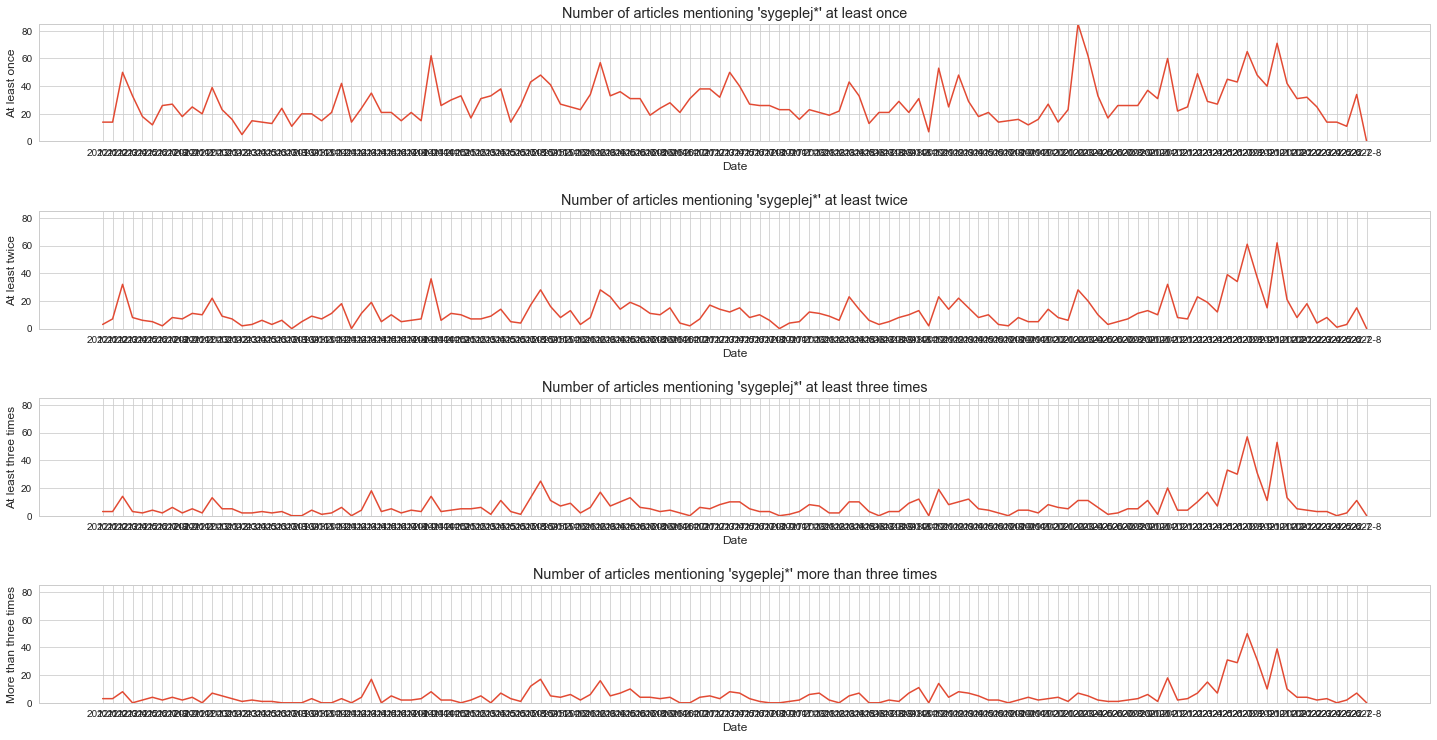

In [428]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=4, ncols=1, sharey=False, figsize=(20,10))
fig.tight_layout(h_pad = 5)
ax[0] = sns.lineplot(x = 'Date', y = "At least once", data=tv2_freq_df, ax=ax[0])
_ = ax[0].set(ylim=(0, 85))
_ = ax[0].set_title("Number of articles mentioning 'sygeplej*' at least once")

ax[1] = sns.lineplot(x = 'Date', y = "At least twice", data=tv2_freq_df, ax=ax[1])
_ = ax[1].set(ylim=(0, 85))
_ = ax[1].set_title("Number of articles mentioning 'sygeplej*' at least twice")

ax[2] = sns.lineplot(x = 'Date', y = "At least three times", data=tv2_freq_df, ax=ax[2])
_ = ax[2].set(ylim=(0, 85))
_ = ax[2].set_title("Number of articles mentioning 'sygeplej*' at least three times")

ax[3] = sns.lineplot(x = 'Date', y = "More than three times", data=tv2_freq_df, ax=ax[3])
_ = ax[3].set(ylim=(0, 85))
_ = ax[3].set_title("Number of articles mentioning 'sygeplej*' more than three times")

It seems reasonable to take article in which our search term appears at least twice. The overall tendency is the same but becomes clearer for articles in which the term applies more frequently.

#### DR

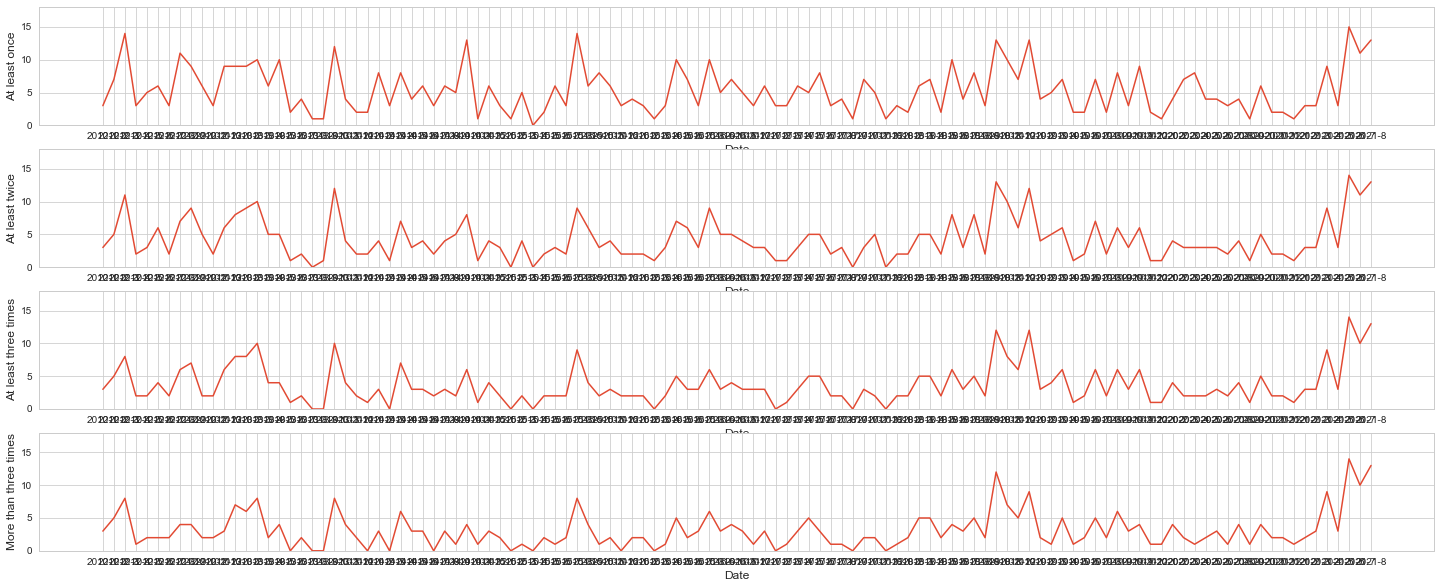

In [429]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=4, ncols=1, sharey=False, figsize=(25,10))

ax[0] = sns.lineplot(x = 'Date', y = "At least once", data=dr_freq_df, ax=ax[0])
_ = ax[0].set(ylim=(0, 18))
ax[1] = sns.lineplot(x = 'Date', y = "At least twice", data=dr_freq_df, ax=ax[1])
_ = ax[1].set(ylim=(0, 18))

ax[2] = sns.lineplot(x = 'Date', y = "At least three times", data=dr_freq_df, ax=ax[2])
_ = ax[2].set(ylim=(0, 18))

ax[3] = sns.lineplot(x = 'Date', y = "More than three times", data=dr_freq_df, ax=ax[3])
_ = ax[3].set(ylim=(0, 18))

We see the same patterns for all articles. This could be explained by the data gathering process. We searched google and got mostly relevant articles. Even though we searched every month, we got more articles for some month and less so for others. In a way, we worked against the search engine. It would be expected that we do not find a pattern because all else equal, the line would be flat. We can reject the hypothesis that there is no development. This is particularly obvious for the corona period. 

It is interesting that for DR articles, we see the number of articles peaking at the beginning of corona crisis.

## Clean plots for TV 2 and DR

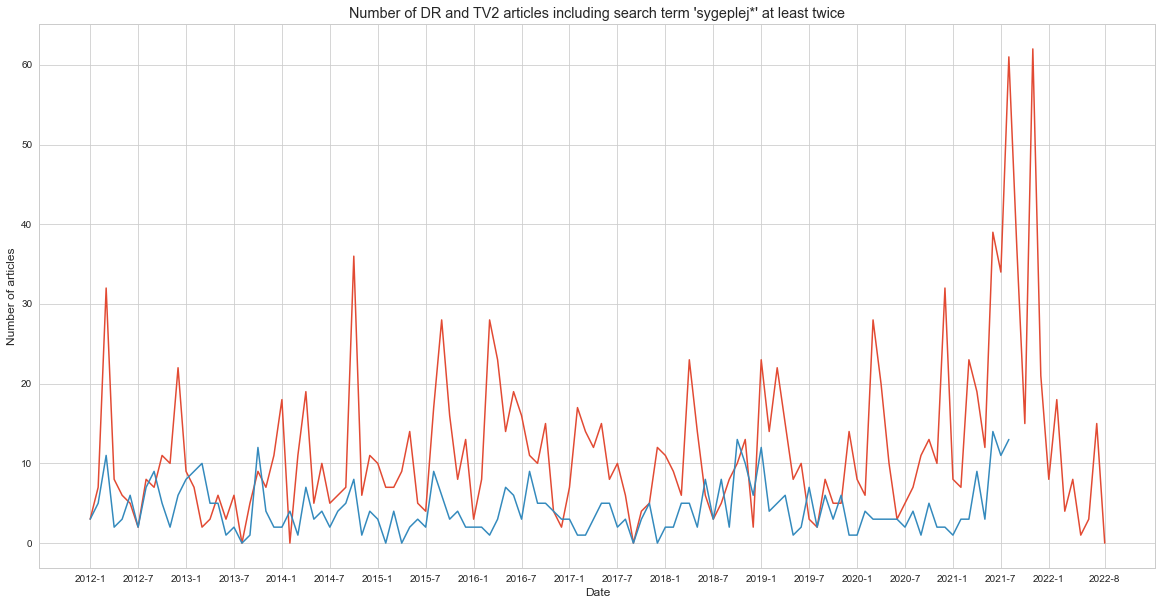

In [441]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(20,10))

sns.lineplot(x = 'Date', y = "At least twice", data=tv2_freq_df)
sns.lineplot(x = 'Date', y = "At least twice", data=dr_freq_df)

_ = plt.title ("Number of DR and TV2 articles including search term 'sygeplej*' at least twice")
_ = plt.ylabel("Number of articles")
_ = plt.xticks([0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 127])

plt.show()

In [ ]:
# Create Plot

fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('X-axis') 
ax1.set_ylabel('Y1-axis', color = 'red') 
ax1.plot(x, data_1, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  


Something is strange in relation to the DR data. After 2021 we cannot find articles that include 'sygeplej' at least once. We checked and looked into an article without finding the term. So it could be that the word does indeed not appear. At least this is the result of the code we run on the articles we have from Jan 2022 and forward. However, this is somewhat surprising and we find this result very surprising against the background of the the development of the frequency curve in the figure. Some DR texts have a different format, so Google links to DR websites but we could not even find the term manually. The sudden stop of the curve is most probably an artefact of the Google search and a change in DR's web infrastructure. At this stage, we continue with the data we have.

Code we used to check the presence of the term 'sygeplej' in articles from 2022:
```python
Checking whether there are articles containing 'sygeplej':
dr_2022 = dr[(dr["date"].dt.year > 2021)]
dr_2022_1x = dr_2022[dr_2022['content'].str.count("sygeplej") >= 1]
dr_2022_1x

```

## Analysis of Tags

### Most frequent Tags

In [197]:
# Define tag-count function
def tag_count(df):
    df_tags=df["tag"].value_counts()
    df_tags=pd.DataFrame(df_tags).reset_index(drop=False)
    df_tags.columns=("tags", "count")
    return df_tags

# Call function
tv2_tags = tag_count(tv2_sygeplej2x)
dr_tags = tag_count(dr_sygeplej2x)

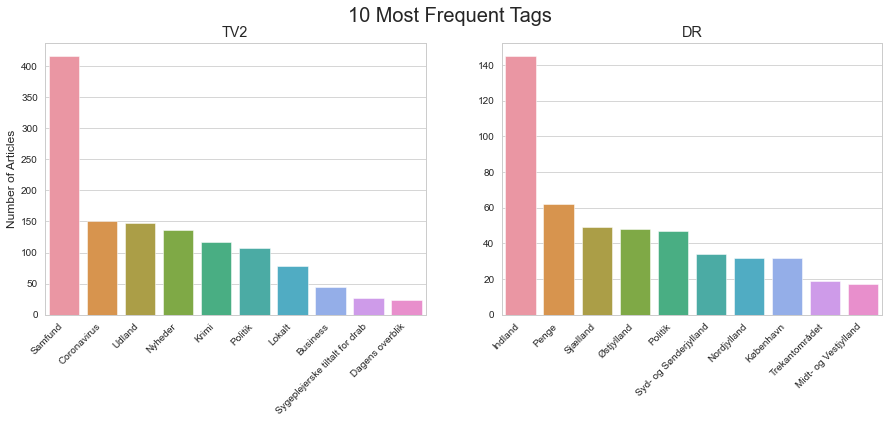

In [223]:
# Plotting count of tags
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))

ax[0] = sns.barplot(x = tv2_tags["tags"][0:10], y = tv2_tags["count"], orient ="v", ax = ax[0])
ax[1] = sns.barplot(x = dr_tags["tags"][0:10], y = dr_tags["count"], orient ="v", ax = ax[1])

_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')

_ = plt.suptitle("10 Most Frequent Tags", size = 20)
_ = ax[0].set_title("TV2")
_ = ax[1].set_title("DR")
_ = ax[0].set_ylabel("Number of Articles")
_ = ax[1].set_ylabel("")

_ = ax[0].set(xlabel=None)
_ = ax[1].set(xlabel=None)

### Usage of tags over time

# Export

In [443]:
tv2_sygeplej1x.to_csv("tv2_sygeplej2x.csv")
dr_sygeplej2x.to_csv("dr_sygeplej2x.csv")